# Advanced Agentic RAG with LangGraph

**A portfolio project showcasing intelligent, adaptive retrieval pipelines**

This system demonstrates production-grade RAG architecture patterns:

- **Dynamic strategy selection** - Semantic, keyword, or hybrid retrieval based on query analysis
- **Quality-driven self-correction** - Automatic query rewrites when retrieval quality is insufficient
- **Multi-stage reranking** - CrossEncoder (top-10) + LLM-as-judge (top-4) for precision
- **HHEM-based hallucination detection** - Claim decomposition with per-chunk HHEM-2.1-Open verification
- **Multi-agent parallel retrieval** - Query decomposition with parallel workers for complex questions

**Architecture**: 7-node StateGraph with distributed intelligence (no central orchestrator)  
**Framework**: LangChain 1.0 & LangGraph 1.0  
**Pattern**: Dynamic Planning and Execution Agents

In [1]:
# Setup & Imports
import os
from dotenv import load_dotenv
load_dotenv()

# All RAG graph variants
from advanced_agentic_rag_langgraph.variants import (
    basic_rag_graph,
    intermediate_rag_graph,
    advanced_rag_graph,
    multi_agent_rag_graph,
)

print("RAG variants loaded:")
print("  - basic_rag_graph: Simplest RAG (semantic search only)")
print("  - intermediate_rag_graph: Query expansion + hybrid + reranking")
print("  - advanced_rag_graph: Full agentic RAG with self-correction")
print("  - multi_agent_rag_graph: Parallel retrieval workers")

RAG variants loaded:
  - basic_rag_graph: Simplest RAG (semantic search only)
  - intermediate_rag_graph: Query expansion + hybrid + reranking
  - advanced_rag_graph: Full agentic RAG with self-correction
  - multi_agent_rag_graph: Parallel retrieval workers


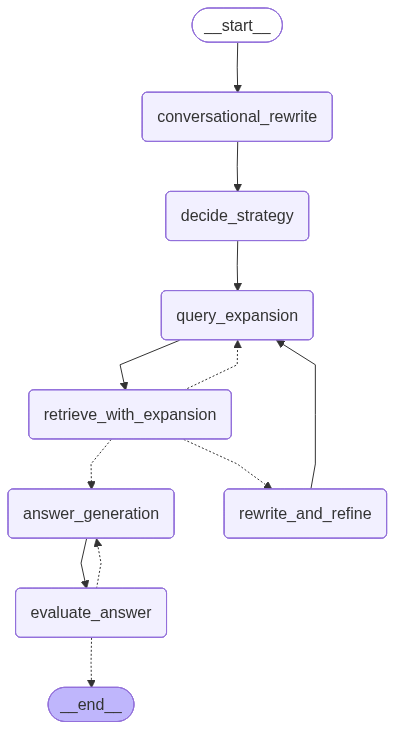

In [2]:
# Architecture Diagram - LangGraph Mermaid Visualization
from IPython.display import Image

# Render the Advanced RAG graph structure
Image(advanced_rag_graph.get_graph().draw_mermaid_png())

## Routing Logic (What the Diagram Doesn't Show)

The graph visualization shows nodes and edges, but the **conditional routing logic** is where the "intelligence" lives:

### `route_after_retrieval` - Quality-Based Branching
```python
if quality >= 0.6:
    return "answer_generation"  # Good enough - proceed

if attempts >= 2:
    return "answer_generation"  # Max attempts - proceed anyway

if ("off_topic" in issues or "wrong_domain" in issues) and (attempts == 1):
    return "query_expansion"    # Early strategy switch
else:
    return "rewrite_and_refine" # Semantic rewrite
```

### `route_after_evaluation` - Answer Quality Gate
```python
if is_refusal:
    return END  # LLM refused - terminal state

if is_answer_sufficient:
    return END

if generation_attempts < 3:
    return "answer_generation"  # Retry with feedback
else:
    return END  # Max attempts reached
```

### Key Design Principles
- **Fix generation with generation** - Don't re-retrieve for generation problems
- **Single correction cycle** - Research shows diminishing returns after first retry
- **Adaptive thresholds** - Lower quality bar (50%) when retrieval is poor

In [3]:
# Initialize Retriever (one-time setup)
# This loads pre-processed Marker JSON chunks (1295 chunks from 10 papers)
from advanced_agentic_rag_langgraph.core import setup_retriever

k_final=4
retriever = setup_retriever(from_marker_json=True, k_final=k_final)
print("\nRetriever initialized with 10 research papers (1295 Marker chunks)")
print("Papers include: Transformers, BERT, ViT, DDPM, CLIP, U-Net, WGAN-GP, Consistency Models")


LOADING FROM MARKER JSON

Found 10 JSON files in C:\Users\kaiho\Downloads\LangChain\advanced-agentic-rag-langgraph\evaluation\corpus_chunks\marker_json_v2
Loaded 10 documents, 1295 chunks

STEP 1: Profiling documents with LLM


DOCUMENT PROFILING
Profiling 10 documents...

Document 1 (AN IMAGE IS WORTH 16X16 WORDS - TRANSFORMERS FOR IMAGE RECOGNITION AT SCALE.pdf):
  Type: conference_paper
  Technical Density: 0.80
  Reading Level: advanced
  Domain: computer_vision, transformers, deep_learning
  Best Strategy: hybrid

Document 2 (Attention Is All You Need.pdf):
  Type: conference_paper
  Technical Density: 0.90
  Reading Level: advanced
  Domain: machine_learning, deep_learning, nlp
  Best Strategy: hybrid

Document 3 (BERT - Pre-training of Deep Bidirectional Transformers for Language Understanding.pdf):
  Type: conference_paper
  Technical Density: 0.90
  Reading Level: advanced
  Domain: nlp, transformers, deep_learning
  Best Strategy: hybrid

Document 4 (Consistency Models - fas

## 4-Tier Architecture Comparison

Each tier adds capabilities while using the **same budget model tier** (GPT-4o-mini) to isolate architectural improvements from model quality:

| Tier | Features | Key Additions |
|------|----------|---------------|
| **Basic** | 1 | Semantic search only, direct LLM generation |
| **Intermediate** | 5 | + Query expansion, hybrid retrieval, CrossEncoder reranking, RRF fusion |
| **Advanced** | 17 | + Strategy selection, two-stage reranking, HHEM detection, quality gates, self-correction loops |
| **Multi-Agent** | 20 | + Query decomposition, parallel retrieval workers, cross-agent LLM relevance scoring |

### Feature Progression
- **Basic**: Pure semantic similarity - works well for simple, direct questions
- **Intermediate**: Query variations improve recall, reranking improves precision
- **Advanced**: Adapts strategy based on query type, retries on poor results
- **Multi-Agent**: Decomposes complex questions, retrieves in parallel, merges results

In [4]:
# Run 4-Tier Comparison
# Using a query from golden dataset so we can calculate F1@4

from advanced_agentic_rag_langgraph.evaluation.retrieval_metrics import calculate_retrieval_metrics
from advanced_agentic_rag_langgraph.validation import HHEMHallucinationDetector

# Import modules to inject shared retriever
import advanced_agentic_rag_langgraph.variants.basic_rag_graph as basic_module
import advanced_agentic_rag_langgraph.variants.intermediate_rag_graph as intermediate_module
import advanced_agentic_rag_langgraph.orchestration.nodes as advanced_module
import advanced_agentic_rag_langgraph.variants.multi_agent_rag_graph as multi_agent_module

# Inject pre-built retriever into all variants
basic_module.adaptive_retriever = retriever
intermediate_module.adaptive_retriever = retriever
advanced_module.adaptive_retriever = retriever
multi_agent_module.adaptive_retriever = retriever

# Query from golden_set_standard_v2.json (transformer_time_complexity)
test_query = "What is the time complexity of self-attention in the Transformer?"
ground_truth_doc_ids = [
      "Attention Is All You Need.pdf_chunk_25",
      "Attention Is All You Need.pdf_chunk_30"
]

graphs = {
    "Basic": basic_rag_graph,
    "Intermediate": intermediate_rag_graph,
    "Advanced": advanced_rag_graph,
    "Multi-Agent": multi_agent_rag_graph,
}

print(f"Query: {test_query}")
print(f"Ground Truth Chunks: {len(ground_truth_doc_ids)} (from attention paper)")
print("="*80)

results = {}
for name, graph in graphs.items():
    print(f"\nRunning {name} RAG...")
    
    initial_state = {
        "user_question": test_query,
        "baseline_query": test_query,
        "messages": [],
        "retrieved_docs": [],
        "retrieval_attempts": 0,
        "query_expansions": [],
        "sub_agent_results": [],
        "ground_truth_doc_ids": ground_truth_doc_ids,
    }
    config = {"configurable": {"thread_id": f"demo-{name.lower().replace('-', '_')}"}}
    
    result = graph.invoke(initial_state, config=config)
    results[name] = result
    
    # Calculate F1@4 for progress display
    docs = result.get("unique_docs_list", [])
    if docs:
        metrics = calculate_retrieval_metrics(docs, ground_truth_doc_ids, k_final)
        f1 = metrics["f1_at_k"]
    else:
        f1 = 0.0
    print(f"  F1@{k_final}: {f1:.0%}")

print("\n" + "="*80)
print("Comparison complete!")

Query: What is the time complexity of self-attention in the Transformer?
Ground Truth Chunks: 2 (from attention paper)

Running Basic RAG...

BASIC RETRIEVAL
Strategy: semantic only (vector similarity)
Top-K: 4 chunks (no reranking)
Retrieved: 4 documents

All 4 chunk IDs (rank order):
  1. AN IMAGE IS WORTH 16X16 WORDS - TRANSFORMERS FOR IMAGE RECOGNITION AT SCALE.pdf_chunk_2
  2. Attention Is All You Need.pdf_chunk_6
  3. Attention Is All You Need.pdf_chunk_9
  4. AN IMAGE IS WORTH 16X16 WORDS - TRANSFORMERS FOR IMAGE RECOGNITION AT SCALE.pdf_chunk_112

Expected chunks: ['Attention Is All You Need.pdf_chunk_25', 'Attention Is All You Need.pdf_chunk_30']
Found: [] | Missing: ['Attention Is All You Need.pdf_chunk_25', 'Attention Is All You Need.pdf_chunk_30']


ANSWER GENERATION
Answer length: 371 chars
Context docs: 4

  F1@4: 0%

Running Intermediate RAG...

QUERY EXPANSION
Original: What is the time complexity of self-attention in the Transformer?
Generated 4 variations


HYBRID RET

In [5]:
# Display Comparison Results
# Calculate F1@4 and Groundedness independently (not from graph state)

hhem_detector = HHEMHallucinationDetector()

print("=" * 80)
print("4-TIER ARCHITECTURE COMPARISON RESULTS")
print("=" * 80)

for name, result in results.items():
    strategy = result.get("retrieval_strategy", "semantic") or "semantic"
    docs = result.get("unique_docs_list", [])
    answer = result.get("final_answer", "")

    # Calculate F1@4 using ground truth
    if docs:
        metrics = calculate_retrieval_metrics(docs, ground_truth_doc_ids, k_final)
        f1_at_k = metrics["f1_at_k"]
    else:
        f1_at_k = 0.0

    # Calculate groundedness using HHEM
    if docs and answer:
        chunks = [doc.page_content for doc in docs[:k_final]]
        groundedness_result = hhem_detector.verify_groundedness(answer, chunks)
        groundedness = groundedness_result["groundedness_score"]
    else:
        groundedness = 0.0

    print(f"\n[{name.upper()}]")
    print(f"Strategy: {strategy}  |  Docs: {len(docs)}  |  F1@4: {f1_at_k:.0%}  |  Groundedness: {groundedness:.0%}")
    print("-" * 80)
    print(answer if answer else "No answer")
    print("=" * 80)

print("\nKey Observations:")
print("- F1@4 measures retrieval quality against known ground truth chunks")
print("- Groundedness measures % of answer claims supported by retrieved context (via HHEM)")
print("- Multi-Agent shows best F1@4 due to query decomposition finding more relevant chunks")

4-TIER ARCHITECTURE COMPARISON RESULTS

[BASIC]
Strategy: semantic  |  Docs: 4  |  F1@4: 0%  |  Groundedness: 0%
--------------------------------------------------------------------------------
The time complexity of self-attention in the Transformer is \(O(n^2 \cdot d)\), where \(n\) is the length of the input sequence and \(d\) is the dimensionality of the representations. This complexity arises because self-attention computes pairwise interactions between all elements in the sequence, leading to a quadratic relationship with respect to the sequence length.

[INTERMEDIATE]
Strategy: semantic  |  Docs: 4  |  F1@4: 33%  |  Groundedness: 80%
--------------------------------------------------------------------------------
The time complexity of self-attention in the Transformer is constant with respect to the sequence length \( n \), as it connects all positions with a constant number of sequentially executed operations. This contrasts with recurrent layers, which require \( O(n) \) sequ

## Deep Dive: Self-Correction Loops

The Advanced RAG tier implements two self-correction mechanisms:

### 1. Retrieval Correction (max 2 attempts)
When `retrieval_quality_score < 0.6`:
- **Path A (off_topic/wrong_domain)**: Switch strategy immediately (semantic ↔ keyword)
- **Path B (other issues)**: Inject suggested keywords into query for better term coverage

### 2. Generation Retry (max 3 attempts)
When answer fails quality evaluation:
- Regenerate with combined feedback (quality issues + hallucination warnings)
- Low temperature: 0.3

### Why Single Correction Cycle?
Research (CRAG, Self-RAG) shows diminishing returns after the first correction. The architecture accepts imperfect retrieval rather than looping indefinitely.

In [ ]:
# Self-Correction Example
# This query might trigger self-correction due to cross-domain scope

correction_query = "How is attention mechanism used differently in NLP vs vision models?"

print(f"Query: {correction_query}")
print("="*80)
print("\nRunning Advanced RAG with potential self-correction...\n")

initial_state = {
    "user_question": correction_query,
    "baseline_query": correction_query,
    "messages": [],
    "retrieved_docs": [],
    "retrieval_attempts": 0,
    "query_expansions": [],
}
config = {"configurable": {"thread_id": "demo-selfcorrect"}}

result = advanced_rag_graph.invoke(initial_state, config=config)

# Display self-correction trace
print("\n\n" + "="*80)
print("EXECUTION TRACE")
print("-"*40)
print(f"Retrieval Attempts: {result.get('retrieval_attempts', 1)}")
print(f"Strategy Used: {result.get('retrieval_strategy', 'semantic')}")

if result.get('strategy_changed'):
    print(f"Strategy Changed: Yes")
    print(f"  Reason: {result.get('strategy_switch_reason', 'N/A')}")

quality = result.get('retrieval_quality_score', 0) or 0
print(f"Final Retrieval Quality: {quality:.0%}")

if result.get('retrieval_quality_issues'):
    print(f"Issues Detected: {', '.join(result['retrieval_quality_issues'])}")

if result.get('retrieval_improvement_suggestion'):
    print(f"Improvement Suggestion: {result['retrieval_improvement_suggestion']}")

print(f"\nGeneration Attempts: {result.get('generation_attempts', 1)}")
print(f"Groundedness: {(result.get('groundedness_score', 0) or 0):.0%}")
print(f"Answer Sufficient: {result.get('is_answer_sufficient', True)}")

print("\n" + "="*80)
print("ANSWER:")
print("-"*40)
print(result.get('final_answer', 'No answer'))

Query: How is attention mechanism used differently in NLP vs vision models?

Running Advanced RAG with potential self-correction...


STRATEGY SELECTION
Query: How is attention mechanism used differently in NLP vs vision models?
Selected: HYBRID
Confidence: 90%
Reasoning: The user is seeking a comparison between the use of attention mechanisms in NLP and vision models, which indicates a need for both conceptual understanding (how attention mechanisms work in each domain) and specific terms (NLP and vision models). This makes a hybrid search the best choice, as it allows for retrieving content that explains the differences while also ensuring that the specific terms 'NLP' and 'vision models' are accurately matched.
Note: Query optimization will happen in query_expansion_node


EXPANSION DECISION
Query: How is attention mechanism used differently in NLP vs vision models?
LLM decision: EXPAND query
Reasoning: The query addresses a complex topic that involves comparing the use of attention

## Evaluation Metrics Summary

All tiers use **budget models** (GPT-4o-mini only) to isolate architectural improvements from model quality.

### Standard Dataset (20 questions, k=4)

| Tier | F1@4 | MRR | nDCG@4 | Groundedness |
|------|------|-----|--------|--------------|
| Basic | 17.3% | 0.254 | 0.236 | 48.6% |
| Intermediate | 22.7% | 0.450 | 0.343 | 70.7% |
| Advanced | 29.3% | 0.600 | 0.484 | 64.1% |
| **Multi-Agent** | **31.7%** | **0.600** | **0.497** | **76.6%** |

*Maximum achievable F1@4 is 64.6% (dataset avg: 2.1 relevant docs/question). Multi-Agent achieves 49% of ceiling.*

### Hard Dataset (10 questions, k=6, multi-document)

| Tier | F1@6 | MRR | nDCG@6 | Groundedness |
|------|------|-----|--------|--------------|
| Basic | 22.0% | 0.458 | 0.300 | 60.4% |
| Intermediate | 25.6% | 0.408 | 0.293 | 62.5% |
| Advanced | 32.5% | **0.750** | 0.460 | **88.9%** |
| **Multi-Agent** | **38.7%** | 0.633 | **0.480** | 87.0% |

*Maximum achievable F1@6 is 84.8% (dataset avg: 4.7 relevant docs/question). Multi-Agent achieves 46% of ceiling.*

### Key Insights

- **83% retrieval improvement** (F1@4: 17.3% -> 31.7%) with budget models only
- Multi-Agent shows +76% F1 improvement over Basic on hard dataset
- Query decomposition helps find relevant documents across multiple aspects
- Architecture provides value independent of model quality

## Conclusion

### Key Takeaways

1. **Architecture > Model Size** - The graph structure provides value independent of model quality. Budget tier demonstrates the RAG intelligence; higher tiers add polish.

2. **Distributed Decision-Making** - No central orchestrator. The StateGraph itself is the agent, with routing functions encoding planning logic.

3. **Quality-Driven Flow** - Every routing point evaluates results and decides next action. Poor retrieval triggers correction; poor generation triggers retry.

4. **Multi-Agent for Complexity** - Query decomposition with parallel workers significantly improves retrieval on complex, multi-faceted questions.

### Source Code

```
src/advanced_agentic_rag_langgraph/
    core/              # State, model tiers, retriever setup
    evaluation/        # Metrics framework (F1, MRR, nDCG)
    orchestration/     # Main graph, nodes, routing
    retrieval/         # Strategy selection, reranking
    validation/        # HHEM hallucination detection
    variants/          # Basic, Intermediate, Advanced, Multi-Agent
```